# Final project - Information Security
Gabriel Beloso e Rafaela Vilela

**Outputs:**
- `results/metricas_finais.csv`
- `results/plots/*.png`


In [30]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve


## Leitura dos pares (dataset LFW)

In [31]:
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

In [32]:

def read_pairs_lfw_images(path_file, base_dir):
    """
    Read the file 'pairs.csv', load images, convert to gray scale and return the pairs and their label.
    Return: list of tuples (imagem_array1, imagem_array2, label)
    label=1: same person | label=0: different persons
    """
    pairs = []

    if not os.path.exists(path_file):
        raise FileNotFoundError(f"Pair file not found: {path_file}")

    with open(path_file, 'r') as f:
        lines = f.readlines()[1:] 

    print(f"Processing {len(lines)} lines from pairs file...")

    for line in lines:
        parts = line.strip().split(',')

        if parts and parts[-1] == '':
            parts = parts[:-1]

        img1_path_rel = ""
        img2_path_rel = ""
        label = 0

        if len(parts) == 3:
            name = parts[0]
            id1 = int(parts[1])
            id2 = int(parts[2])

            img1_path_rel = f"{name}/{name}_{id1:04d}.jpg"
            img2_path_rel = f"{name}/{name}_{id2:04d}.jpg"
            label = 1

        elif len(parts) == 4:
            name1 = parts[0]
            id1 = int(parts[1])
            name2 = parts[2]
            id2 = int(parts[3])

            img1_path_rel = f"{name1}/{name1}_{id1:04d}.jpg"
            img2_path_rel = f"{name2}/{name2}_{id2:04d}.jpg"
            label = 0
        else:
            continue

        full_path1 = os.path.join(base_dir, fr'lfw-deepfunneled\lfw-deepfunneled', img1_path_rel)
        full_path2 = os.path.join(base_dir, fr'lfw-deepfunneled\lfw-deepfunneled', img2_path_rel)
        
        img1_data = cv2.imread(full_path1, cv2.IMREAD_GRAYSCALE)
        img2_data = cv2.imread(full_path2, cv2.IMREAD_GRAYSCALE)

        if img1_data is None or img2_data is None:
            print(f"Warning: Fail to load: {img1_path_rel} ou {img2_path_rel}")
            continue

        pairs.append((img1_data, img2_data, label))

    print(f"✅ Total valid pairs: {len(pairs)}")
    return pairs

BASE_DIR = path
PAIRS_CSV = os.path.join(BASE_DIR, "pairs.csv")

pairs = read_pairs_lfw_images(PAIRS_CSV, BASE_DIR)

images_1 = [p[0] for p in pairs]
images_2 = [p[1] for p in pairs]
labels   = [p[2] for p in pairs]

print("✅ Prepared pairs:", len(pairs))


Processing 6000 lines from pairs file...
✅ Total valid pairs: 6000
✅ Prepared pairs: 6000


## Features extractor
HOG (resize 64×64), LBPH (histogram LBP uniform), Hu Moments.

In [33]:

def get_hog_from_images(image):
    a = resize(image, (64, 64), anti_aliasing=True)
    return hog(
        a, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), block_norm='L2-Hys',
        feature_vector=True
    )

def get_lbp_from_images(image):
    METHOD = 'uniform'
    P_neighbors = 8
    R_radius = 1
    n_bins = P_neighbors + 2
    lbp = local_binary_pattern(image, P_neighbors, R_radius, METHOD)
    return np.histogram(lbp.ravel(), bins=range(0, n_bins + 1), density=True)[0]

def get_hu_moments(image):
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    moments = cv2.moments(thresh)
    hu = cv2.HuMoments(moments)
    for i in range(7):
        val = hu[i]
        if val != 0:
            hu[i] = -1 * np.copysign(1.0, val) * np.log10(abs(val))
        else:
            hu[i] = 0

    return hu.flatten()


## Metrics + ROC + EER.

In [34]:

def compute_eer(fpr, tpr):
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[idx] + fnr[idx]) / 2
    return eer, idx

def evaluate_and_save(y_true, y_pred, y_score, feature_name, model_name, output_dir="results"):
    os.makedirs(output_dir, exist_ok=True)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    eer, eer_idx = compute_eer(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.scatter(fpr[eer_idx], tpr[eer_idx], label=f"EER = {eer:.4f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - {feature_name} - {model_name}")
    plt.legend()
    plt.grid(True)

    roc_path = f"{output_dir}/ROC_{feature_name}_{model_name}.png"
    plt.savefig(roc_path, dpi=300, bbox_inches="tight")
    plt.close()

    cm_df = pd.DataFrame(cm, index=["Real 0", "Real 1"], columns=["Pred 0", "Pred 1"])
    cm_csv = f"{output_dir}/CM_{feature_name}_{model_name}.csv"
    cm_df.to_csv(cm_csv)

    return {
        "Feature": feature_name,
        "Modelo": model_name,
        "Acuracia": acc,
        "Precisao": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": roc_auc,
        "EER": eer
    }


## Execution Nested Cross Validation (SVM / KNN / RF)

In [35]:
def run_experiment_and_save(features_1, features_2, labels, feature_name, output_dir):
    X_all = np.abs(features_1 - features_2)
    y_all = np.array(labels).astype(int)

    classifiers_config = {
        'SVM': {
            'model': SVC(probability=True), # probability=True para o EER/ROC_AUC
            'params': {
                'clf__C': [0.1, 1, 10],
                'clf__kernel': ['rbf', 'linear']
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'clf__n_estimators': [100, 200],
                'clf__max_depth': [None, 10, 20]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'clf__n_neighbors': [3, 5, 7, 11],
                'clf__weights': ['uniform', 'distance']
            }
        }
    }

    metrics = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }

    all_results = []

    for name, config in classifiers_config.items():
        print(f"Executando Nested CV para: {feature_name} + {name}...")
        
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', config['model'])
        ])

        external_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        internal_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        params_search = GridSearchCV(
            estimator=pipe, 
            param_grid=config['params'], 
            cv=internal_cv,
            scoring='roc_auc',
            n_jobs=-1
        )

        scores = cross_validate(
            params_search, 
            X_all, y_all, 
            cv=external_cv,
            scoring=metrics,
            return_train_score=False, 
            n_jobs=-1
        )

        res_dict = {'Extractor': feature_name, 'Classifier': name}
        for m in metrics.keys():
            res_dict[f'mean_{m}'] = np.mean(scores[f'test_{m}'])
            res_dict[f'std_{m}'] = np.std(scores[f'test_{m}'])

        all_results.append(res_dict)
        
    final_df = pd.DataFrame(all_results)
    final_df.to_csv(os.path.join(output_dir, feature_name + ".csv"))
    return final_df

## Execução HOG / LBPH / HUM
Resultados armazenados em `results/metricas_finais.csv`.

In [36]:
os.makedirs("results", exist_ok=True)

In [37]:
# HUM (Hu Moments)
f1_hu = np.array([get_hu_moments(img) for img in images_1])
f2_hu = np.array([get_hu_moments(img) for img in images_2])
df_hu = run_experiment_and_save(f1_hu, f2_hu, labels, "HUM", "results")
df_hu

Executando Nested CV para: HUM + SVM...
Executando Nested CV para: HUM + RandomForest...
Executando Nested CV para: HUM + KNN...


,Extractor,Classifier,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,mean_roc_auc,std_roc_auc
0,HUM,SVM,0.555333,0.008410,0.541313,0.008264,0.734667,0.064389,0.621847,0.020805,0.574630,0.010588
1,HUM,RandomForest,0.551500,0.014399,0.546208,0.012429,0.606667,0.026415,0.574745,0.017997,0.565939,0.012704
2,HUM,KNN,0.525667,0.016778,0.525252,0.016337,0.533333,0.021213,0.529196,0.017953,0.539755,0.015882


In [38]:
# LBP
f1_lbp = np.array([get_lbp_from_images(img) for img in images_1])
f2_lbp = np.array([get_lbp_from_images(img) for img in images_2])
df_lbp = run_experiment_and_save(f1_lbp, f2_lbp, labels, "LBPH", "results")
df_lbp

Executando Nested CV para: LBPH + SVM...
Executando Nested CV para: LBPH + RandomForest...
Executando Nested CV para: LBPH + KNN...


,Extractor,Classifier,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,mean_roc_auc,std_roc_auc
0,LBPH,SVM,0.550833,0.012660,0.553523,0.018165,0.547000,0.063730,0.547552,0.022476,0.572806,0.013909
1,LBPH,RandomForest,0.549000,0.005855,0.547926,0.005443,0.560000,0.014530,0.553827,0.008898,0.566678,0.005384
2,LBPH,KNN,0.521167,0.013505,0.519226,0.012195,0.572667,0.014476,0.544609,0.012658,0.529256,0.011368


In [39]:
# HOG - 
f1_hog = np.array([get_hog_from_images(img) for img in images_1])
f2_hog = np.array([get_hog_from_images(img) for img in images_2])
df_hog = run_experiment_and_save(f1_hog, f2_hog, labels, "HOG", "results")
df_hog

Executando Nested CV para: HOG + SVM...
Executando Nested CV para: HOG + RandomForest...
Executando Nested CV para: HOG + KNN...


,Extractor,Classifier,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,mean_roc_auc,std_roc_auc
0,HOG,SVM,0.707000,0.013246,0.723862,0.017379,0.670000,0.017638,0.695716,0.013612,0.777292,0.010685
1,HOG,RandomForest,0.687167,0.012787,0.701327,0.017091,0.652667,0.012320,0.676020,0.011923,0.752876,0.016420
2,HOG,KNN,0.539667,0.007703,0.521404,0.004253,0.967000,0.004643,0.677498,0.004613,0.726586,0.011179


In [40]:
df_final = pd.concat([df_lbp, df_hog, df_hu], axis=0).reset_index(drop=True)
df_final.to_csv("results/metricas_finais.csv", index=False)

display(df_final)
print("✅ Saved in: results/metricas_finais.csv")


,Extractor,Classifier,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,mean_roc_auc,std_roc_auc
0,LBPH,SVM,0.550833,0.012660,0.553523,0.018165,0.547000,0.063730,0.547552,0.022476,0.572806,0.013909
1,LBPH,RandomForest,0.549000,0.005855,0.547926,0.005443,0.560000,0.014530,0.553827,0.008898,0.566678,0.005384
2,LBPH,KNN,0.521167,0.013505,0.519226,0.012195,0.572667,0.014476,0.544609,0.012658,0.529256,0.011368
3,HOG,SVM,0.707000,0.013246,0.723862,0.017379,0.670000,0.017638,0.695716,0.013612,0.777292,0.010685
4,HOG,RandomForest,0.687167,0.012787,0.701327,0.017091,0.652667,0.012320,0.676020,0.011923,0.752876,0.016420
5,HOG,KNN,0.539667,0.007703,0.521404,0.004253,0.967000,0.004643,0.677498,0.004613,0.726586,0.011179
6,HUM,SVM,0.555333,0.008410,0.541313,0.008264,0.734667,0.064389,0.621847,0.020805,0.574630,0.010588
7,HUM,RandomForest,0.551500,0.014399,0.546208,0.012429,0.606667,0.026415,0.574745,0.017997,0.565939,0.012704
8,HUM,KNN,0.525667,0.016778,0.525252,0.016337,0.533333,0.021213,0.529196,0.017953,0.539755,0.015882


✅ Saved in: results/metricas_finais.csv


## Graphical comparasion

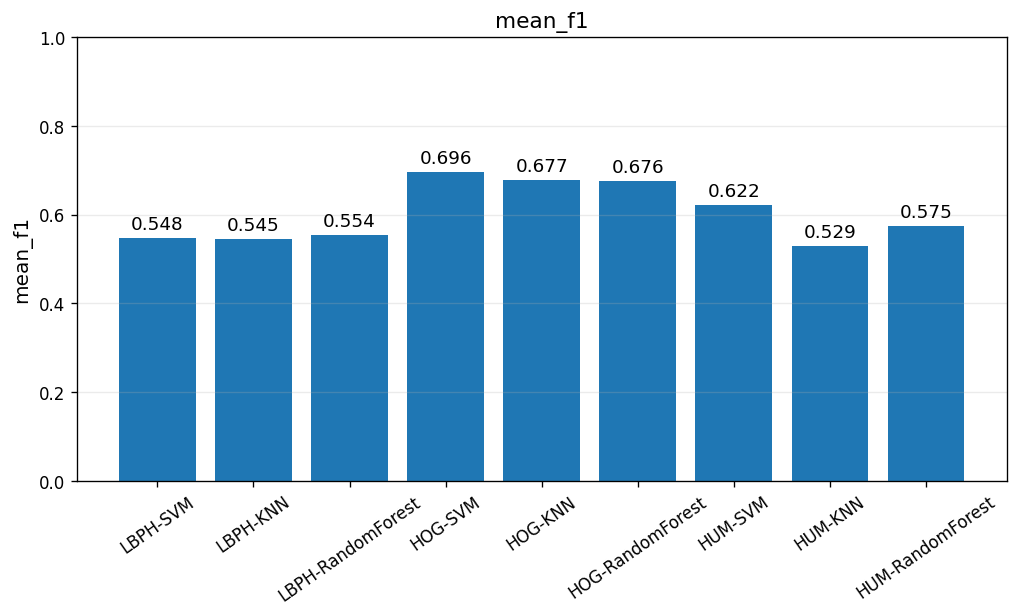

✅ Saved in: results/plots\bar_all_mean_f1.png


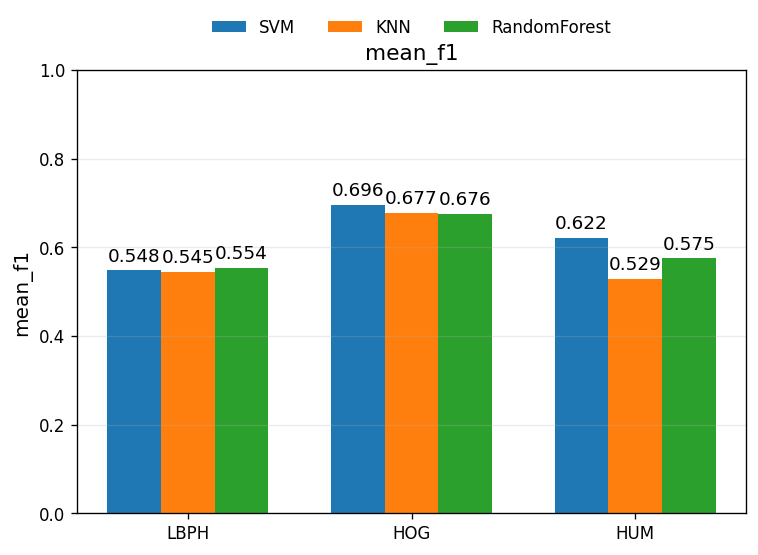

✅ Saved in: results/plots\bar_grouped_feature_mean_f1.png


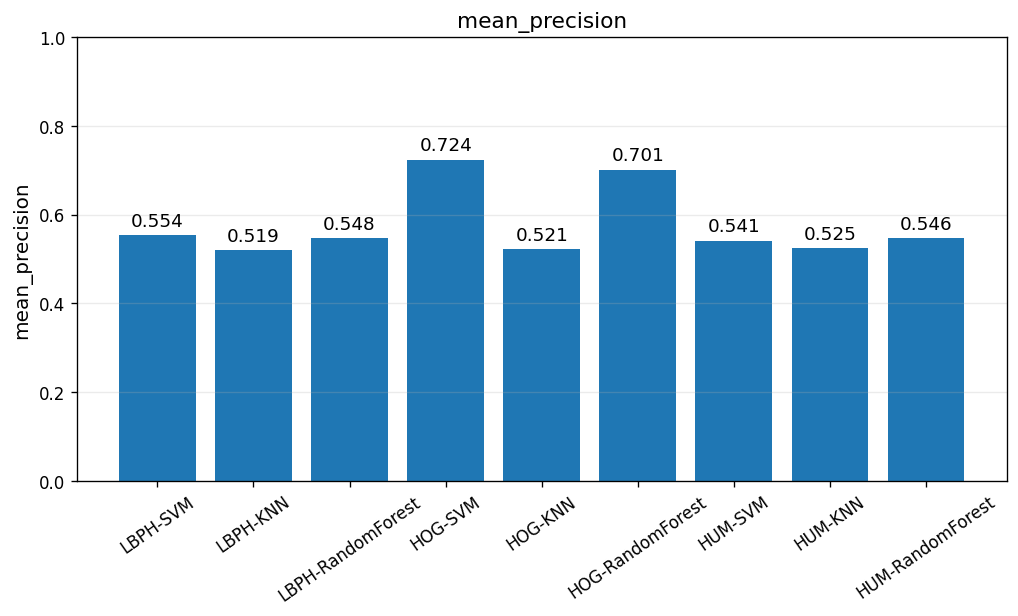

✅ Saved in: results/plots\bar_all_mean_precision.png


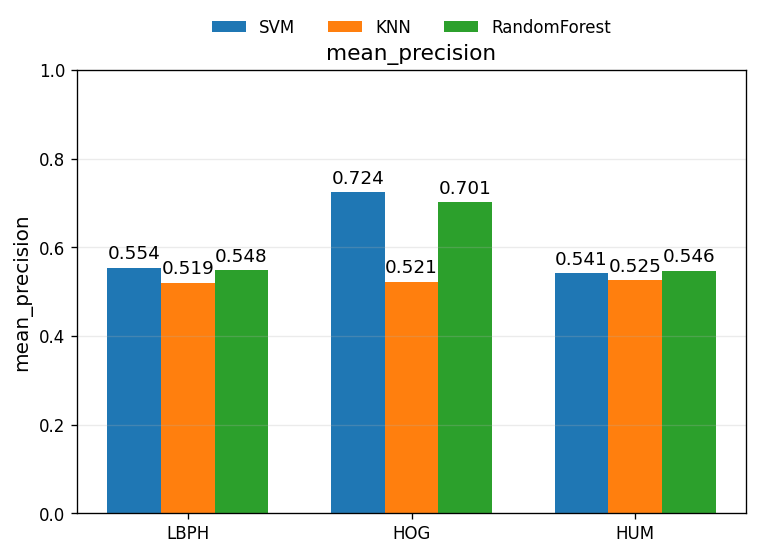

✅ Saved in: results/plots\bar_grouped_feature_mean_precision.png


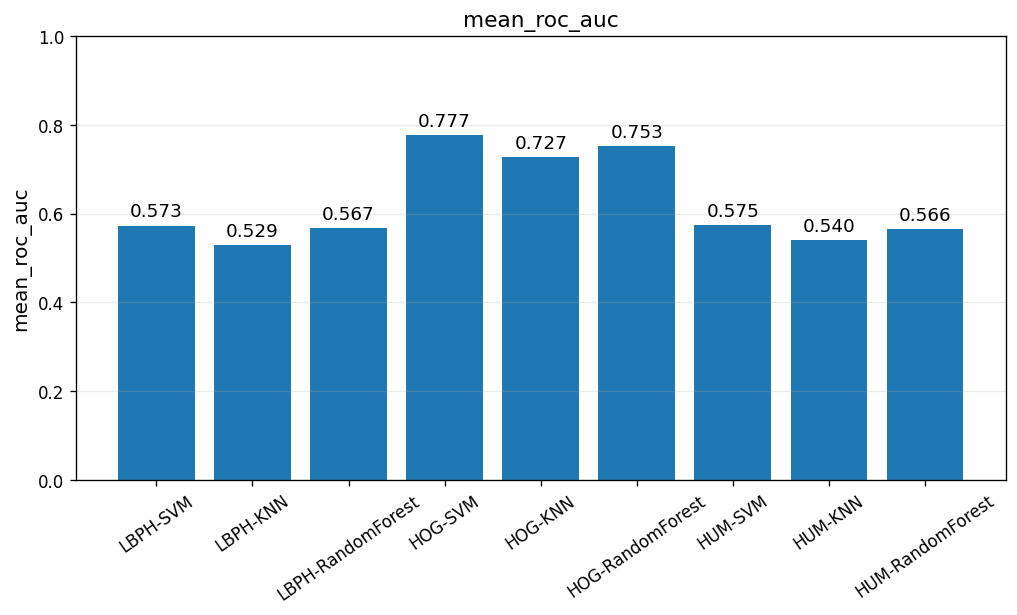

✅ Saved in: results/plots\bar_all_mean_roc_auc.png


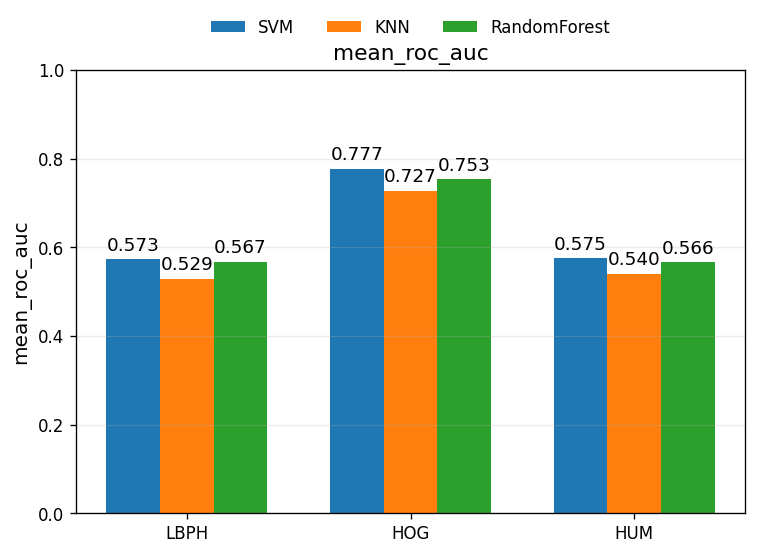

✅ Saved in: results/plots\bar_grouped_feature_mean_roc_auc.png


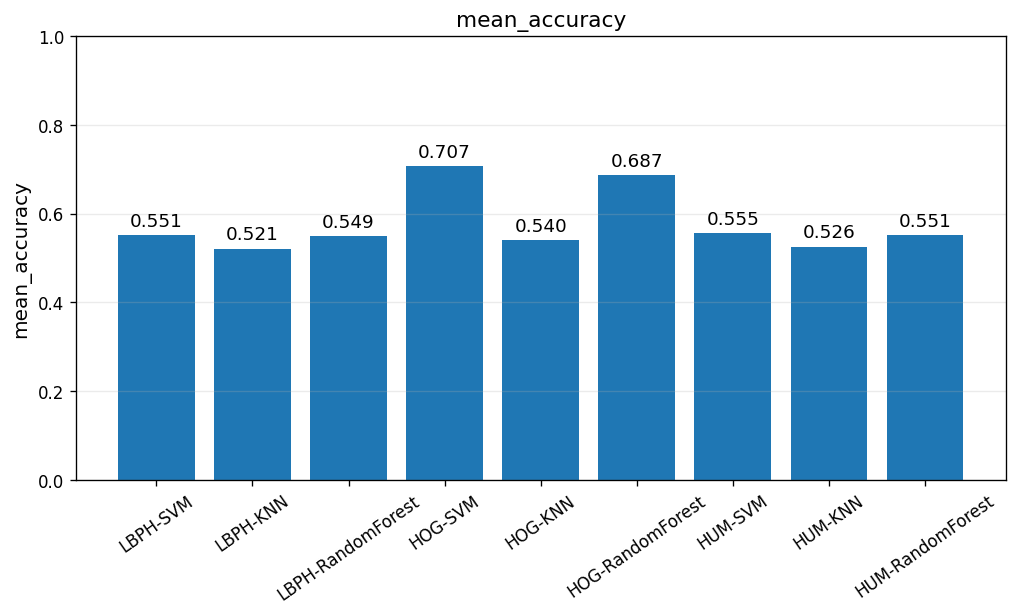

✅ Saved in: results/plots\bar_all_mean_accuracy.png


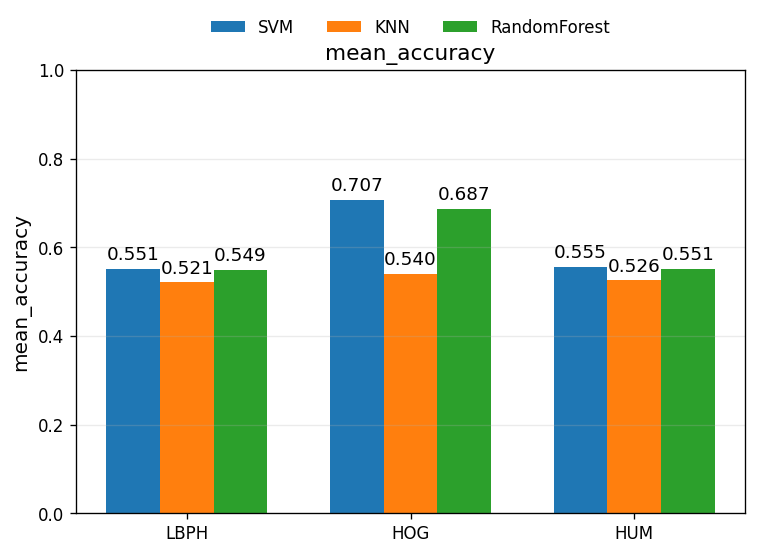

✅ Saved in: results/plots\bar_grouped_feature_mean_accuracy.png


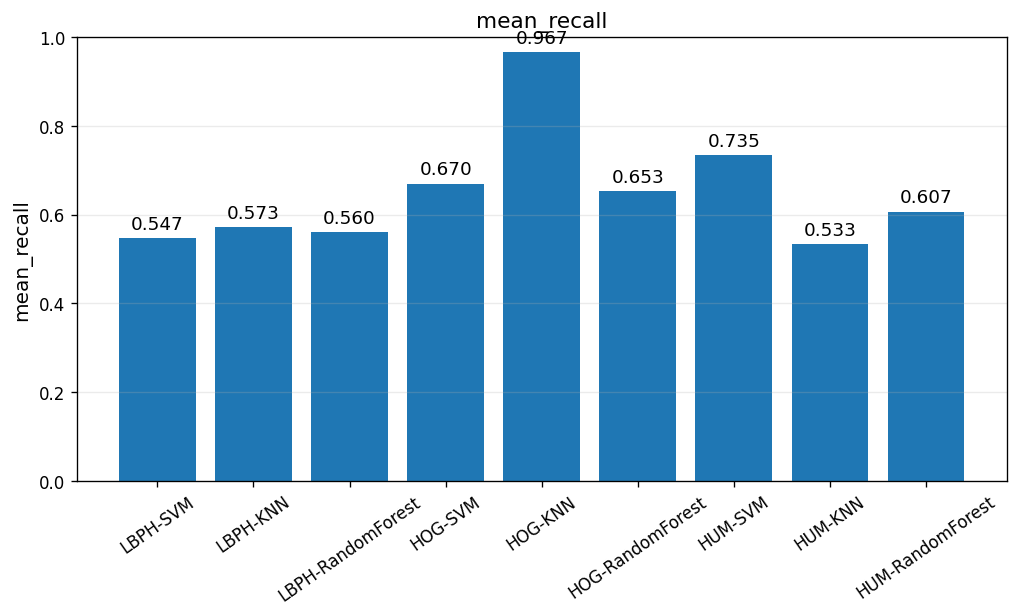

✅ Saved in: results/plots\bar_all_mean_recall.png


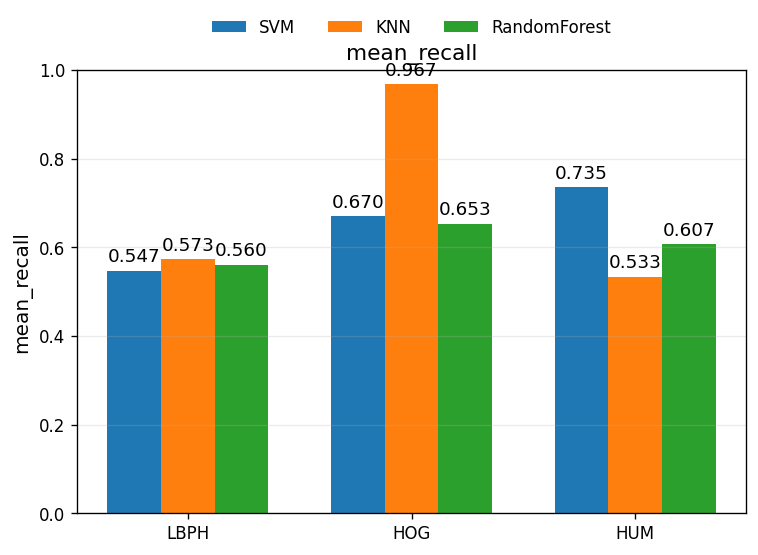

✅ Saved in: results/plots\bar_grouped_feature_mean_recall.png
✅ Graphcis saved in results/plots/


In [41]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results/metricas_finais.csv")

feature_order = ["LBPH", "HOG", "HUM"]
model_order = ["SVM", "KNN", "RandomForest"]

df["Extractor"] = pd.Categorical(df["Extractor"], categories=feature_order, ordered=True)
df["Classifier"]  = pd.Categorical(df["Classifier"],  categories=model_order,  ordered=True)
df = df.sort_values(["Extractor", "Classifier"]).reset_index(drop=True)

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 120
})

OUT_DIR = "results/plots"
os.makedirs(OUT_DIR, exist_ok=True)

def _add_value_labels(ax, fmt="{:.3f}"):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(fmt.format(h),
                    (p.get_x() + p.get_width()/2, h),
                    ha="center", va="bottom",
                    xytext=(0, 3), textcoords="offset points")

def save_and_show(fig, filename):
    path = os.path.join(OUT_DIR, filename)
    fig.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved in: {path}")

def plot_metric_all_bars(df, metric, ylim=(0, 1)):
    labels = [f"{r.Extractor}-{r.Classifier}" for _, r in df.iterrows()]
    values = df[metric].astype(float).values

    fig, ax = plt.subplots(figsize=(10, 4.8))
    ax.bar(labels, values)
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_ylim(*ylim)
    ax.grid(axis="y", alpha=0.25)
    ax.tick_params(axis="x", rotation=35)
    _add_value_labels(ax)
    save_and_show(fig, f"bar_all_{metric}.png")

def plot_metric_grouped_by_feature(df, metric, ylim=(0, 1)):
    pivot = df.pivot(index="Extractor", columns="Classifier", values=metric).reindex(feature_order)[model_order]

    x = np.arange(len(pivot.index))
    width = 0.24

    fig, ax = plt.subplots(figsize=(7.2, 4.8))
    for i, model in enumerate(model_order):
        ax.bar(x + (i-1)*width, pivot[model].values.astype(float), width, label=model)

    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index.tolist())
    ax.set_ylim(*ylim)
    ax.grid(axis="y", alpha=0.25)
    ax.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.15))
    _add_value_labels(ax)
    save_and_show(fig, f"bar_grouped_feature_{metric}.png")

metrics = {
        'mean_accuracy',
        'mean_precision',
        'mean_recall',
        'mean_f1',
        'mean_roc_auc'
    }

for m in metrics:
    plot_metric_all_bars(df, m, ylim=(0, 1))
    plot_metric_grouped_by_feature(df, m, ylim=(0, 1))

print("✅ Graphcis saved in results/plots/")


# Curva ROC

In [42]:
def generate_comparative_roc_and_save(features_dict, labels, output_dir="results", filename="feature_roc"):
    """
    Generate ROC comparative curve
    """
    labels = np.array(labels).astype(int)
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    plt.figure(figsize=(10, 8))
    
    colors = {'HOG': 'blue', 'LBPH': 'green', 'HUM': 'red'}
    mean_fpr = np.linspace(0, 1, 100)

    for feat_name, X in features_dict.items():
        X = np.array(X)
        print(f"Processing ROC curve for: {feat_name}...")
        
        ext_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        int_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', SVC(probability=True, kernel='rbf'))
        ])
        
        params = {'clf__C': [0.1, 1, 10], 'clf__gamma': ['scale']}
        grid = GridSearchCV(pipe, params, cv=int_cv, scoring='roc_auc', n_jobs=-1)

        tprs = []
        aucs = []

        for train, test in ext_cv.split(X, labels):
            grid.fit(X[train], labels[train])
            y_proba = grid.predict_proba(X[test])[:, 1]
            fpr, tpr, _ = roc_curve(labels[test], y_proba)
            
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(auc(mean_fpr, interp_tpr))

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        plt.plot(mean_fpr, mean_tpr, color=colors.get(feat_name, 'black'),
                 label=f'{feat_name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
                 lw=2, alpha=0.8)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Acaso', alpha=0.8)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (1 - FRR)')
    plt.title('Comparison between feature extractors (Classificador: SVM)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    save_path = os.path.join(output_dir, f"{filename}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Graphic sucessfully saved in: {save_path}")
    
    plt.close() 

In [43]:
X_hog = np.abs(f1_hog - f2_hog)
X_lbp = np.abs(f1_lbp - f2_lbp)
X_hum = np.abs(f1_hu - f2_hu)
features = {'HOG': X_hog, 'LBPH': X_lbp, 'HUM': X_hum}
generate_comparative_roc_and_save(features, labels)

Processing ROC curve for: HOG...
Processing ROC curve for: LBPH...
Processing ROC curve for: HUM...
Graphic sucessfully saved in: results\feature_roc.png
